In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from keras.layers import LSTM, Dense, Activation
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import math
from sklearn.metrics import mean_squared_error

In [2]:
# Read CSV into a dataframe

# Setting the name of the Excel file which contains the solar generation data

file_name = 'PV_BY_Day.xlsx'

# Reading the Excel file using pandas. The engine 'openpyxl' is specified since it's a common engine for reading .xlsx files

df_generation = pd.read_excel(file_name, engine='openpyxl')

# Setting the name of the CSV file which contains the solar exposure data

file_name = 'IDCJAC0016_066207_1800_Data.csv'

# Reading the CSV file using pandas

df_exposure = pd.read_csv(file_name)

# Reading the 'totaldemand_nsw.csv' file into a dataframe

df_demand = pd.read_csv('totaldemand_nsw.csv', sep = ',', header = 0, parse_dates=['DATETIME'], dayfirst=True)

# Reading the 'temperature_nsw.csv' file into a dataframe

df_temp = pd.read_csv('temperature_nsw.csv', sep = ',', header = 0, parse_dates=['DATETIME'], dayfirst=True)

In [3]:
# Setting the name of the CSV files for the humidity data

file_name1 = 'humidity_wsp_20160916_20180729.xlsx'
file_name2 = 'humidity_wsp_20180730_20200610.xlsx'
file_name3 = 'humidity_wsp_20200611_20200930.xlsx'
file_name4 = 'humidity_wsp_20201001_20220731.xlsx'

# Reading the CSV files into dataframes

df_humidity_wsp1 = pd.read_excel(file_name1, engine='openpyxl')
df_humidity_wsp2 = pd.read_excel(file_name2, engine='openpyxl')
df_humidity_wsp3 = pd.read_excel(file_name3, engine='openpyxl')
df_humidity_wsp4 = pd.read_excel(file_name4, engine='openpyxl')

df_humidity_wsp = pd.concat([df_humidity_wsp1, df_humidity_wsp2, df_humidity_wsp3, df_humidity_wsp4], ignore_index=True)

In [4]:
# Define a list of strings which represent column names for a dataframe

column_names = ['date', 'time', 'wsp', 'humidity']

# Rename the columns of the 'df_humidity_wsp' dataframe

df_humidity_wsp.columns = column_names

In [5]:
# Convert 'date' column to datetime
df_humidity_wsp['date'] = pd.to_datetime(df_humidity_wsp['date'], format='%d/%m/%Y')
df_humidity_wsp['date'] = df_humidity_wsp['date'].dt.strftime('%Y-%m-%d')
                                         
# Group by 'date' and compute mean for 'wsp' and 'humidity'
agg_df_humidity_wsp = df_humidity_wsp.groupby('date').agg({'wsp': 'mean', 'humidity': 'mean'}).reset_index()

agg_df_humidity_wsp['date'] = pd.to_datetime(agg_df_humidity_wsp['date'], format='%Y-%m-%d')

In [6]:
#Filling in all nan humidity and wsp values with average for that date

agg_df_humidity_wsp['date'] = pd.to_datetime(agg_df_humidity_wsp['date'])

# Extract month and day from the date
agg_df_humidity_wsp['month'] = agg_df_humidity_wsp['date'].dt.month
agg_df_humidity_wsp['day'] = agg_df_humidity_wsp['date'].dt.day

# Calculate average values for wsp and humidity for each month-day combination
avg_values = agg_df_humidity_wsp.groupby(['month', 'day'])[['wsp', 'humidity']].mean().reset_index()

# Merge average values back to the original dataframe
agg_df_humidity_wsp = agg_df_humidity_wsp.merge(avg_values, on=['month', 'day'], suffixes=('', '_avg'))

# Replace NaN values with the average values
agg_df_humidity_wsp['wsp'].fillna(agg_df_humidity_wsp['wsp_avg'], inplace=True)
agg_df_humidity_wsp['humidity'].fillna(agg_df_humidity_wsp['humidity_avg'], inplace=True)

# Drop the auxiliary columns
agg_df_humidity_wsp.drop(columns=['month', 'day', 'wsp_avg', 'humidity_avg'], inplace=True)

In [7]:
# Extract the 'date' portion from the 'DATETIME' column of the 'df_demand' dataframe

df_demand['date'] = df_demand['DATETIME'].dt.date

# Convert the 'date' column in the 'df_demand' dataframe to a datetime format (from a date format)

df_demand['date'] = pd.to_datetime(df_demand['date'])

# Drop the first column (i.e., at index 0) of the 'df_demand' dataframe

df_demand = df_demand.drop(df_demand.iloc[:,0:1].columns, axis=1)

# Rename the 'TOTALDEMAND' column to 'total_demand' in the 'df_demand' dataframe

df_demand = df_demand.rename(columns={'TOTALDEMAND': 'total_demand'})

# Filter the 'df_demand' dataframe to only include rows where the 'date' is between 2016-09-16 and 2022-07-30 (inclusive)

df_demand = df_demand[df_demand['date'] < '2022-08-01']

df_demand = df_demand[df_demand['date'] >= '2016-09-16']

# Group the 'df_demand' dataframe by the 'date' column, summing the 'total_demand' for each date, and resetting the index

agg_df_demand = df_demand.groupby(['date'])['total_demand'].sum().reset_index()

In [8]:
# Extract the date portion from the 'DATETIME' column and store it in a new 'date' column.

df_temp['date'] = df_temp['DATETIME'].dt.date

# Convert the 'date' column from strings to datetime objects.

df_temp['date'] = pd.to_datetime(df_temp['date'])

# Drop the first column from the DataFrame

df_temp = df_temp.drop(df_temp.iloc[:,0:1].columns, axis=1)

# Rename the 'TEMPERATURE' column to 'temperature'.

df_temp = df_temp.rename(columns={'TEMPERATURE': 'temperature'})

# Filter the 'df_temp' dataframe to only include rows where the 'date' is between 2016-09-16 and 2022-07-30 (inclusive)

df_temp = df_temp[df_temp['date'] < '2022-08-01']
df_temp = df_temp[df_temp['date'] >= '2016-09-16']

# Group the DataFrame by 'date' and calculate the mean temperature for each date group.

agg_df_temp = df_temp.groupby(['date'])['temperature'].mean().reset_index()

In [9]:
# Group the DataFrame 'df_generation' by 'INTERVAL_DATETIME' and calculate the mean of 'GWh' for each group.

df_generation = df_generation.groupby('INTERVAL_DATETIME')['GWh'].mean().reset_index()

# Convert the 'INTERVAL_DATETIME' column to datetime objects by extracting only the date part.

df_generation['INTERVAL_DATETIME'] = pd.to_datetime(df_generation['INTERVAL_DATETIME'].dt.date)

# Define a list of column names.

column_names = ['date', 'solar_generation']

# Rename the columns of 'df_generation' using the defined column names.

df_generation.columns = column_names

# The date range for this project is 16/09/2016 - 01/08/2022. The next section filters the data to this scoped range.

df_generation = df_generation[df_generation['date'] < '2022-08-01']


# Group the filtered DataFrame by 'date' and calculate the sum of 'solar_generation' for each date group.

agg_df_generation = df_generation.groupby(['date'])['solar_generation'].sum().reset_index()

In [10]:
# Drop the first two columns from the DataFrame 'df_exposure'.

df_exposure = df_exposure.drop(df_exposure.columns[[0,1]], axis = 1)

# Define a list of column names.

column_names = ['year', 'month', 'day', 'daily_solar_exposure']

# Rename the columns of 'df_exposure' using the defined column names.

df_exposure.columns = column_names

# Create a new 'date' column by combining 'year', 'month', and 'day' columns into a datetime object.

df_exposure['date'] = pd.to_datetime(df_exposure[['year', 'month', 'day']])

# Filter the 'df_exposure' dataframe to only include rows where the 'date' is between 2016-09-16 and 2022-07-30 (inclusive)

df_exposure = df_exposure[df_exposure['date'] < '2022-08-01']
df_exposure = df_exposure[df_exposure['date'] >= '2016-09-16']

# There is one null daily_solar_exposure value on the 26th of November 2017. In order to fix this issue, we can use the average solar exposure for the 26th November.

avg_exposure = df_exposure[(df_exposure['month'] == 11) & (df_exposure['day'] == 26)]['daily_solar_exposure'].mean()
df_exposure.loc[(df_exposure['year'] == 2017) & (df_exposure['month'] == 11) & (df_exposure['day'] == 26), 'daily_solar_exposure'] = avg_exposure

# Dropping fields that are no longer required

df_exposure = df_exposure.drop(columns=['year', 'month', 'day'])

In [11]:
# Aggregating the Solar Generation Data to daily

agg_df_generation = df_generation.groupby(['date'])['solar_generation'].sum().reset_index()

In [12]:
# Joining datasets using outer joins on date

merged_df = agg_df_demand.merge(agg_df_temp, on='date', how='outer')\
              .merge(agg_df_generation, on='date', how='outer')\
              .merge(df_exposure, on='date', how='outer')\
              .merge(agg_df_humidity_wsp, on='date', how='outer')

In [13]:
# Only keep the columns 'date', 'total_demand', 'temperature', 'wsp', and 'humidity'.

df = merged_df[['date', 'total_demand', 'temperature', 'wsp', 'humidity']]

# Add a new column 'day_of_year' to the 'df' DataFrame, which extracts the day of the year from the 'date' column.

df['day_of_year'] = df['date'].dt.dayofyear

<ipython-input-13-5aadf26846aa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day_of_year'] = df['date'].dt.dayofyear


In [14]:
# Calculate a normalized 'day_of_year' value in the range [0, 2*pi].
df["day_of_year_norm"] = 2 * math.pi * df["day_of_year"] / df["day_of_year"].max()

# Calculate the cosine of the normalized 'day_of_year_norm' values and store them in a new column 'day_of_year_cos'.

df["day_of_year_cos"] = np.cos(df["day_of_year_norm"])

# Calculate the sine of the normalized 'day_of_year_norm' values and store them in a new column 'day_of_year_sin'.

df["day_of_year_sin"] = np.sin(df["day_of_year_norm"])

In [15]:
# Store the dates before removing the column
date_values = df['date'] 

# Only keep the columns 'total_demand', 'temperature', 'wsp','humidity', 'day_of_year_cos', 'day_of_year_sin'.
df = df[['total_demand', 'temperature', 'wsp', 'humidity', 'day_of_year_cos', 'day_of_year_sin']]

In [16]:
# Setting the seed for reproducibility
seed_value = 5152
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [17]:
# Split the DataFrame 'df' into training and temporary DataFrames 'train_df' and 'temp_df'.
# The training set will contain 60% of the data, and the temporary set will contain 40%.
train_df, temp_df = train_test_split(df, test_size=0.4, shuffle=False)

# Split the temporary DataFrame 'temp_df' into validation and test DataFrames 'valid_df' and 'test_df'.
# The validation set will contain 20% of the original data, and the test set will contain the remaining 20%.
valid_df, test_df = train_test_split(temp_df, test_size=0.5, shuffle=False)

# Split the list of dates 'date_values' in the same manner as the data.
# This ensures that the dates correspond to the respective subsets of data.
# The training, validation, and test dates are stored in 'temp_dates' and 'test_dates'.
_, temp_dates = train_test_split(date_values, test_size=0.4, shuffle=False)
_, test_dates = train_test_split(temp_dates, test_size=0.5, shuffle=False)

In [18]:
# Normalization

# Create an instance of the MinMaxScaler

scaler = MinMaxScaler()

# Normalize the 'train_df' dataset and store the result in the 'train' variable.
# The 'fit_transform' method scales the data and also computes the scaling parameters based on the training data.

train = scaler.fit_transform(train_df)

# Normalize the 'valid_df' dataset using the scaling parameters learned from the training data.

valid = scaler.transform(valid_df)

# Normalize the 'test_df' dataset using the same scaling parameters learned from the training data.

test = scaler.transform(test_df)

In [19]:
# Setting optimized parameters
learning_rate_opt = 0.0026939851101072426
look_back_opt = 32
batch_size_opt = 4
activation_opt = 'relu'

In [20]:
# Function to create datasets for LSTM

def create_dataset(dataset, look_back=10):

    # Initialize empty lists to store sequences of input features (dataX) and target values (dataY).
    
    dataX, dataY = [], []

    # Iterate through the dataset to create sequences.

    for i in range(len(dataset)-look_back-1):
        
        # Extract a subsequence of 'look_back' time steps from the dataset.
        
        a = dataset[i:(i+look_back), :]
        
        # Append the subsequence to the 'dataX' list.        
        
        dataX.append(a)
        
        # Append the next time step's value (target) to the 'dataY' list.
        # The target value is taken from the next time step after the 'look_back' window.     
        
        dataY.append(dataset[i + look_back, 0])
        
    # Convert the lists of sequences into numpy arrays and return them.        

    return np.array(dataX), np.array(dataY)

In [21]:
# Build LSTM Model
def build_lstm_model(learning_rate, look_back, activation, batch_size):

    # Create training and validation datasets using the 'create_dataset' function.
    
    trainX, trainY = create_dataset(train, look_back)
    validX, validY = create_dataset(valid, look_back)

    # Create a Sequential model.
    
    model = Sequential()
    
    # Add an LSTM layer with 50 units and specify the input shape.
    
    model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2])))
    
    # Add an activation function (specified by the 'activation' parameter).    
    
    model.add(Activation(activation))
    
    # Add a Dense layer with a single output unit for regression.    
    
    model.add(Dense(1))
    
    # Define the optimizer with the given learning rate.
    
    optimizer = Adam(learning_rate=learning_rate)
    
    # Compile the model with mean squared error (MSE) as the loss function and the specified optimizer.
    
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    
    # Return the model and the training/validation data for further training and evaluation.    
    
    return model, trainX, trainY, validX, validY

In [22]:
num_runs = 100
all_predictions = []

# Loop for a specified number of runs (num_runs)

for run in range(num_runs):
    
    # Set random seeds for NumPy and TensorFlow to ensure reproducibility.
    
    np.random.seed(seed_value + run)
    tf.random.set_seed(seed_value + run)
    
    # Build an LSTM model with specified hyperparameters and obtain training and validation data.    
    
    model, trainX, trainY, validX, validY = build_lstm_model(learning_rate_opt, look_back_opt, activation_opt, batch_size_opt)
    
    # Set up early stopping  
    
    early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    
    # Train the model with training data and validation data, using early stopping.    
    
    model.fit(trainX, trainY, epochs=1000, batch_size=batch_size_opt, validation_data=(validX, validY), verbose=1, callbacks=[early_stop])
    
    # Create a test dataset with the same look_back parameter.    
    
    testX, testY = create_dataset(test, look_back_opt)
    
    # Make predictions on the test dataset.    
    
    test_predictions = model.predict(testX)
    
    # Append the test predictions from this run to the 'all_predictions' list.    
    
    all_predictions.append(test_predictions)

# Calculate the average of predictions from all runs (an ensemble prediction).

avg_predictions = np.mean(np.array(all_predictions), axis=0)

# Inverse transform the scaled predictions to obtain predictions in the original scale.

avg_predictions_original = scaler.inverse_transform(np.concatenate((avg_predictions, testX[:,0,1:]), axis=1))[:,0]

# Adjust the test dates to account for the look_back offset.
test_dates = test_dates[look_back_opt+1:].values

Epoch 1/1000
314/314 [==============================] - 3s 7ms/step - loss: 0.0205 - val_loss: 0.0120
Epoch 2/1000
314/314 [==============================] - 2s 6ms/step - loss: 0.0154 - val_loss: 0.0120
Epoch 3/1000
314/314 [==============================] - 2s 6ms/step - loss: 0.0138 - val_loss: 0.0121
Epoch 4/1000
314/314 [==============================] - 2s 6ms/step - loss: 0.0127 - val_loss: 0.0087
Epoch 5/1000
314/314 [==============================] - 2s 6ms/step - loss: 0.0108 - val_loss: 0.0109
Epoch 6/1000
314/314 [==============================] - 2s 6ms/step - loss: 0.0112 - val_loss: 0.0118
Epoch 7/1000
314/314 [==============================] - 2s 6ms/step - loss: 0.0108 - val_loss: 0.0115
Epoch 8/1000
314/314 [==============================] - 2s 6ms/step - loss: 0.0105 - val_loss: 0.0105
Epoch 9/1000
314/314 [==============================] - 2s 6ms/step - loss: 0.0104 - val_loss: 0.0083
Epoch 10/1000
314/314 [==============================] - 2s 6ms/step - loss: 0.010

Epoch 33/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0073 - val_loss: 0.0067
Epoch 34/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0068 - val_loss: 0.0072
Epoch 35/1000
314/314 [==============================] - 2s 6ms/step - loss: 0.0067 - val_loss: 0.0059
Epoch 36/1000
314/314 [==============================] - 2s 6ms/step - loss: 0.0067 - val_loss: 0.0073
Epoch 37/1000
314/314 [==============================] - 2s 6ms/step - loss: 0.0069 - val_loss: 0.0068
Epoch 38/1000
314/314 [==============================] - 2s 6ms/step - loss: 0.0065 - val_loss: 0.0074
Epoch 39/1000
314/314 [==============================] - 2s 6ms/step - loss: 0.0066 - val_loss: 0.0076
Epoch 40/1000
314/314 [==============================] - 2s 6ms/step - loss: 0.0065 - val_loss: 0.0080
Epoch 41/1000
314/314 [==============================] - 2s 6ms/step - loss: 0.0064 - val_loss: 0.0063
Epoch 42/1000
314/314 [==============================] - 2s 6ms/step - lo

Epoch 7/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0104 - val_loss: 0.0121
Epoch 8/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0104 - val_loss: 0.0081
Epoch 9/1000
314/314 [==============================] - 2s 6ms/step - loss: 0.0103 - val_loss: 0.0095
Epoch 10/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0099 - val_loss: 0.0101
Epoch 11/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0100 - val_loss: 0.0080
Epoch 12/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0095 - val_loss: 0.0076
Epoch 13/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0090 - val_loss: 0.0079
Epoch 14/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0087 - val_loss: 0.0079
Epoch 15/1000
314/314 [==============================] - 2s 6ms/step - loss: 0.0082 - val_loss: 0.0075
Epoch 16/1000
314/314 [==============================] - 2s 6ms/step - loss:

13/13 [==============================] - 0s 3ms/step
Epoch 1/1000
314/314 [==============================] - 3s 7ms/step - loss: 0.0202 - val_loss: 0.0157
Epoch 2/1000
314/314 [==============================] - 2s 6ms/step - loss: 0.0163 - val_loss: 0.0148
Epoch 3/1000
314/314 [==============================] - 2s 6ms/step - loss: 0.0133 - val_loss: 0.0140
Epoch 4/1000
314/314 [==============================] - 2s 6ms/step - loss: 0.0114 - val_loss: 0.0090
Epoch 5/1000
314/314 [==============================] - 2s 6ms/step - loss: 0.0106 - val_loss: 0.0091
Epoch 6/1000
314/314 [==============================] - 2s 6ms/step - loss: 0.0107 - val_loss: 0.0127
Epoch 7/1000
314/314 [==============================] - 2s 6ms/step - loss: 0.0104 - val_loss: 0.0101
Epoch 8/1000
314/314 [==============================] - 2s 6ms/step - loss: 0.0105 - val_loss: 0.0076
Epoch 9/1000
314/314 [==============================] - 2s 6ms/step - loss: 0.0104 - val_loss: 0.0116
Epoch 10/1000
314/314 [======

314/314 [==============================] - 2s 6ms/step - loss: 0.0158 - val_loss: 0.0112
Epoch 3/1000
314/314 [==============================] - 2s 6ms/step - loss: 0.0139 - val_loss: 0.0101
Epoch 4/1000
314/314 [==============================] - 2s 6ms/step - loss: 0.0127 - val_loss: 0.0114
Epoch 5/1000
314/314 [==============================] - 2s 6ms/step - loss: 0.0118 - val_loss: 0.0111
Epoch 6/1000
314/314 [==============================] - 2s 6ms/step - loss: 0.0109 - val_loss: 0.0090
Epoch 7/1000
314/314 [==============================] - 2s 6ms/step - loss: 0.0111 - val_loss: 0.0105
Epoch 8/1000
314/314 [==============================] - 2s 6ms/step - loss: 0.0109 - val_loss: 0.0124
Epoch 9/1000
314/314 [==============================] - 2s 6ms/step - loss: 0.0106 - val_loss: 0.0087
Epoch 10/1000
314/314 [==============================] - 2s 6ms/step - loss: 0.0102 - val_loss: 0.0108
Epoch 11/1000
314/314 [==============================] - 2s 6ms/step - loss: 0.0104 - val_loss

Epoch 15/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0081 - val_loss: 0.0070
Epoch 16/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0084 - val_loss: 0.0073
Epoch 17/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0079 - val_loss: 0.0065
Epoch 18/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0078 - val_loss: 0.0078
Epoch 19/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0083 - val_loss: 0.0068
Epoch 20/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0076 - val_loss: 0.0067
Epoch 21/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0077 - val_loss: 0.0072
Epoch 22/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0078 - val_loss: 0.0066
Epoch 23/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0077 - val_loss: 0.0062
Epoch 24/1000
314/314 [==============================] - 2s 7ms/step - lo

Epoch 24/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0071 - val_loss: 0.0068
Epoch 25/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0070 - val_loss: 0.0063
Epoch 26/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0073 - val_loss: 0.0067
Epoch 27/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0069 - val_loss: 0.0081
Epoch 28/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0072 - val_loss: 0.0104
Epoch 29/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0070 - val_loss: 0.0072
Epoch 30/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0072 - val_loss: 0.0067
Epoch 31/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0068 - val_loss: 0.0078
Epoch 32/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0066 - val_loss: 0.0063
Epoch 33/1000
314/314 [==============================] - 2s 7ms/step - lo

314/314 [==============================] - 2s 7ms/step - loss: 0.0063 - val_loss: 0.0082
Epoch 49/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0063 - val_loss: 0.0093
Epoch 50/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0066 - val_loss: 0.0071
Epoch 51/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0066 - val_loss: 0.0085
Epoch 52/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0060 - val_loss: 0.0076
Epoch 53/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0063 - val_loss: 0.0064
Epoch 54/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0060 - val_loss: 0.0061
Epoch 55/1000
13/13 [==============================] - 0s 3ms/step
Epoch 1/1000
314/314 [==============================] - 4s 8ms/step - loss: 0.0223 - val_loss: 0.0143
Epoch 2/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0157 - val_loss: 0.0114
Epoch 3/1000
314/314 [

Epoch 18/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0079 - val_loss: 0.0089
Epoch 19/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0077 - val_loss: 0.0079
Epoch 20/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0083 - val_loss: 0.0116
Epoch 21/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0077 - val_loss: 0.0090
Epoch 22/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0075 - val_loss: 0.0069
Epoch 23/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0077 - val_loss: 0.0069
Epoch 24/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0080 - val_loss: 0.0081
Epoch 25/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0071 - val_loss: 0.0063
Epoch 26/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0076 - val_loss: 0.0070
Epoch 27/1000
314/314 [==============================] - 2s 7ms/step - lo

314/314 [==============================] - 2s 7ms/step - loss: 0.0052 - val_loss: 0.0066
Epoch 58/1000
13/13 [==============================] - 0s 3ms/step
Epoch 1/1000
314/314 [==============================] - 4s 8ms/step - loss: 0.0194 - val_loss: 0.0124
Epoch 2/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0160 - val_loss: 0.0134
Epoch 3/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0136 - val_loss: 0.0106
Epoch 4/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0123 - val_loss: 0.0102
Epoch 5/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0110 - val_loss: 0.0095
Epoch 6/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0108 - val_loss: 0.0087
Epoch 7/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0104 - val_loss: 0.0078
Epoch 8/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0101 - val_loss: 0.0084
Epoch 9/1000
314/314 [======

Epoch 15/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0087 - val_loss: 0.0077
Epoch 16/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0083 - val_loss: 0.0082
Epoch 17/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0084 - val_loss: 0.0094
Epoch 18/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0081 - val_loss: 0.0089
Epoch 19/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0079 - val_loss: 0.0076
Epoch 20/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0077 - val_loss: 0.0101
Epoch 21/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0076 - val_loss: 0.0064
Epoch 22/1000
314/314 [==============================] - 2s 6ms/step - loss: 0.0079 - val_loss: 0.0075
Epoch 23/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0077 - val_loss: 0.0095
Epoch 24/1000
314/314 [==============================] - 2s 6ms/step - lo

314/314 [==============================] - 2s 7ms/step - loss: 0.0067 - val_loss: 0.0073
Epoch 42/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0066 - val_loss: 0.0068
Epoch 43/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0063 - val_loss: 0.0060
Epoch 44/1000
314/314 [==============================] - 2s 8ms/step - loss: 0.0064 - val_loss: 0.0087
Epoch 45/1000
314/314 [==============================] - 2s 8ms/step - loss: 0.0062 - val_loss: 0.0068
Epoch 46/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0063 - val_loss: 0.0084
Epoch 47/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0063 - val_loss: 0.0059
Epoch 48/1000
13/13 [==============================] - 0s 3ms/step
Epoch 1/1000
314/314 [==============================] - 4s 8ms/step - loss: 0.0199 - val_loss: 0.0145
Epoch 2/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0154 - val_loss: 0.0119
Epoch 3/1000
314/314 [

Epoch 16/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0078 - val_loss: 0.0087
Epoch 17/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0077 - val_loss: 0.0064
Epoch 18/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0077 - val_loss: 0.0068
Epoch 19/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0074 - val_loss: 0.0070
Epoch 20/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0073 - val_loss: 0.0075
Epoch 21/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0074 - val_loss: 0.0086
Epoch 22/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0076 - val_loss: 0.0094
Epoch 23/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0073 - val_loss: 0.0084
Epoch 24/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0071 - val_loss: 0.0095
Epoch 25/1000
314/314 [==============================] - 2s 7ms/step - lo

314/314 [==============================] - 2s 8ms/step - loss: 0.0065 - val_loss: 0.0065
Epoch 39/1000
314/314 [==============================] - 2s 8ms/step - loss: 0.0067 - val_loss: 0.0059
Epoch 40/1000
314/314 [==============================] - 2s 8ms/step - loss: 0.0065 - val_loss: 0.0073
Epoch 41/1000
314/314 [==============================] - 2s 8ms/step - loss: 0.0072 - val_loss: 0.0065
Epoch 42/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0065 - val_loss: 0.0066
Epoch 43/1000
314/314 [==============================] - 2s 8ms/step - loss: 0.0065 - val_loss: 0.0070
Epoch 44/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0066 - val_loss: 0.0069
Epoch 45/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0063 - val_loss: 0.0063
Epoch 46/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0065 - val_loss: 0.0078
Epoch 47/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0062 - v

Epoch 15/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0089 - val_loss: 0.0081
Epoch 16/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0085 - val_loss: 0.0091
Epoch 17/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0085 - val_loss: 0.0091
Epoch 18/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0078 - val_loss: 0.0072
Epoch 19/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0080 - val_loss: 0.0093
Epoch 20/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0077 - val_loss: 0.0089
Epoch 21/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0076 - val_loss: 0.0098
Epoch 22/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0079 - val_loss: 0.0081
Epoch 23/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0074 - val_loss: 0.0076
Epoch 24/1000
314/314 [==============================] - 2s 7ms/step - lo

314/314 [==============================] - 2s 7ms/step - loss: 0.0074 - val_loss: 0.0093
Epoch 23/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0085 - val_loss: 0.0076
Epoch 24/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0100 - val_loss: 0.0087
Epoch 25/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0084 - val_loss: 0.0066
Epoch 26/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0075 - val_loss: 0.0086
Epoch 27/1000
314/314 [==============================] - 2s 8ms/step - loss: 0.0074 - val_loss: 0.0081
Epoch 28/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0071 - val_loss: 0.0066
Epoch 29/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0068 - val_loss: 0.0075
Epoch 30/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0069 - val_loss: 0.0066
Epoch 31/1000
314/314 [==============================] - 2s 8ms/step - loss: 0.0069 - v

314/314 [==============================] - 2s 7ms/step - loss: 0.0118 - val_loss: 0.0081
Epoch 5/1000
314/314 [==============================] - 2s 8ms/step - loss: 0.0112 - val_loss: 0.0083
Epoch 6/1000
314/314 [==============================] - 2s 8ms/step - loss: 0.0105 - val_loss: 0.0093
Epoch 7/1000
314/314 [==============================] - 2s 8ms/step - loss: 0.0104 - val_loss: 0.0095
Epoch 8/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0104 - val_loss: 0.0151
Epoch 9/1000
314/314 [==============================] - 2s 8ms/step - loss: 0.0102 - val_loss: 0.0090
Epoch 10/1000
314/314 [==============================] - 2s 8ms/step - loss: 0.0103 - val_loss: 0.0090
Epoch 11/1000
314/314 [==============================] - 3s 8ms/step - loss: 0.0101 - val_loss: 0.0080
Epoch 12/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0096 - val_loss: 0.0088
Epoch 13/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0093 - val_lo

Epoch 27/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0072 - val_loss: 0.0057
Epoch 28/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0072 - val_loss: 0.0065
Epoch 29/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0069 - val_loss: 0.0065
Epoch 30/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0071 - val_loss: 0.0061
Epoch 31/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0068 - val_loss: 0.0078
Epoch 32/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0067 - val_loss: 0.0064
Epoch 33/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0066 - val_loss: 0.0076
Epoch 34/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0066 - val_loss: 0.0073
Epoch 35/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0070 - val_loss: 0.0074
Epoch 36/1000
314/314 [==============================] - 2s 7ms/step - lo

Epoch 9/1000
314/314 [==============================] - 3s 8ms/step - loss: 0.0101 - val_loss: 0.0084
Epoch 10/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0100 - val_loss: 0.0081
Epoch 11/1000
314/314 [==============================] - 2s 8ms/step - loss: 0.0092 - val_loss: 0.0072
Epoch 12/1000
314/314 [==============================] - 3s 8ms/step - loss: 0.0089 - val_loss: 0.0088
Epoch 13/1000
314/314 [==============================] - 3s 8ms/step - loss: 0.0084 - val_loss: 0.0070
Epoch 14/1000
314/314 [==============================] - 3s 10ms/step - loss: 0.0085 - val_loss: 0.0074
Epoch 15/1000
314/314 [==============================] - 3s 9ms/step - loss: 0.0081 - val_loss: 0.0071
Epoch 16/1000
314/314 [==============================] - 2s 8ms/step - loss: 0.0082 - val_loss: 0.0091
Epoch 17/1000
314/314 [==============================] - 2s 8ms/step - loss: 0.0080 - val_loss: 0.0068
Epoch 18/1000
314/314 [==============================] - 2s 7ms/step - lo

314/314 [==============================] - 2s 7ms/step - loss: 0.0074 - val_loss: 0.0077
Epoch 22/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0075 - val_loss: 0.0067
Epoch 23/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0075 - val_loss: 0.0082
Epoch 24/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0073 - val_loss: 0.0064
Epoch 25/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0074 - val_loss: 0.0074
Epoch 26/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0073 - val_loss: 0.0066
Epoch 27/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0069 - val_loss: 0.0071
Epoch 28/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0072 - val_loss: 0.0063
Epoch 29/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0072 - val_loss: 0.0070
Epoch 30/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0070 - v

Epoch 23/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0076 - val_loss: 0.0083
Epoch 24/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0077 - val_loss: 0.0065
Epoch 25/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0073 - val_loss: 0.0078
Epoch 26/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0075 - val_loss: 0.0076
Epoch 27/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0073 - val_loss: 0.0094
Epoch 28/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0073 - val_loss: 0.0073
Epoch 29/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0072 - val_loss: 0.0087
Epoch 30/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0073 - val_loss: 0.0099
Epoch 31/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0070 - val_loss: 0.0077
Epoch 32/1000
314/314 [==============================] - 2s 7ms/step - lo

Epoch 19/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0083 - val_loss: 0.0089
Epoch 20/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0083 - val_loss: 0.0086
Epoch 21/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0079 - val_loss: 0.0092
Epoch 22/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0080 - val_loss: 0.0068
Epoch 23/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0079 - val_loss: 0.0088
Epoch 24/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0079 - val_loss: 0.0081
Epoch 25/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0073 - val_loss: 0.0080
Epoch 26/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0075 - val_loss: 0.0080
Epoch 27/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0074 - val_loss: 0.0076
Epoch 28/1000
314/314 [==============================] - 2s 7ms/step - lo

Epoch 22/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0077 - val_loss: 0.0072
Epoch 23/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0076 - val_loss: 0.0077
Epoch 24/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0075 - val_loss: 0.0066
Epoch 25/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0076 - val_loss: 0.0073
Epoch 26/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0074 - val_loss: 0.0085
Epoch 27/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0073 - val_loss: 0.0092
Epoch 28/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0075 - val_loss: 0.0065
Epoch 29/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0075 - val_loss: 0.0077
Epoch 30/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0072 - val_loss: 0.0087
Epoch 31/1000
314/314 [==============================] - 2s 7ms/step - lo

314/314 [==============================] - 2s 7ms/step - loss: 0.0061 - val_loss: 0.0058
Epoch 51/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0062 - val_loss: 0.0061
Epoch 52/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0058 - val_loss: 0.0061
Epoch 53/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0058 - val_loss: 0.0061
Epoch 54/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0058 - val_loss: 0.0062
Epoch 55/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0055 - val_loss: 0.0070
Epoch 56/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0056 - val_loss: 0.0062
Epoch 57/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0059 - val_loss: 0.0065
Epoch 58/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0053 - val_loss: 0.0065
Epoch 59/1000
13/13 [==============================] - 0s 3ms/step
Epoch 1/1000
314/314

Epoch 13/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0087 - val_loss: 0.0078
Epoch 14/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0087 - val_loss: 0.0079
Epoch 15/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0082 - val_loss: 0.0085
Epoch 16/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0083 - val_loss: 0.0068
Epoch 17/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0082 - val_loss: 0.0069
Epoch 18/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0075 - val_loss: 0.0074
Epoch 19/1000
314/314 [==============================] - 2s 6ms/step - loss: 0.0074 - val_loss: 0.0069
Epoch 20/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0077 - val_loss: 0.0062
Epoch 21/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0074 - val_loss: 0.0109
Epoch 22/1000
314/314 [==============================] - 2s 7ms/step - lo

314/314 [==============================] - 2s 7ms/step - loss: 0.0074 - val_loss: 0.0073
Epoch 30/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0072 - val_loss: 0.0083
Epoch 31/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0072 - val_loss: 0.0071
Epoch 32/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0070 - val_loss: 0.0076
Epoch 33/1000
314/314 [==============================] - 2s 6ms/step - loss: 0.0069 - val_loss: 0.0072
Epoch 34/1000
13/13 [==============================] - 0s 3ms/step
Epoch 1/1000
314/314 [==============================] - 3s 7ms/step - loss: 0.0201 - val_loss: 0.0108
Epoch 2/1000
314/314 [==============================] - 2s 6ms/step - loss: 0.0152 - val_loss: 0.0101
Epoch 3/1000
314/314 [==============================] - 2s 6ms/step - loss: 0.0132 - val_loss: 0.0118
Epoch 4/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0117 - val_loss: 0.0092
Epoch 5/1000
314/314 [==

Epoch 18/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0077 - val_loss: 0.0070
Epoch 19/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0077 - val_loss: 0.0072
Epoch 20/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0074 - val_loss: 0.0087
Epoch 21/1000
314/314 [==============================] - 2s 6ms/step - loss: 0.0074 - val_loss: 0.0074
Epoch 22/1000
314/314 [==============================] - 2s 6ms/step - loss: 0.0072 - val_loss: 0.0085
Epoch 23/1000
314/314 [==============================] - 2s 6ms/step - loss: 0.0072 - val_loss: 0.0073
Epoch 24/1000
314/314 [==============================] - 2s 6ms/step - loss: 0.0073 - val_loss: 0.0061
Epoch 25/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0074 - val_loss: 0.0065
Epoch 26/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0073 - val_loss: 0.0068
Epoch 27/1000
314/314 [==============================] - 2s 7ms/step - lo

314/314 [==============================] - 2s 7ms/step - loss: 0.0068 - val_loss: 0.0069
Epoch 34/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0067 - val_loss: 0.0067
Epoch 35/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0066 - val_loss: 0.0062
Epoch 36/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0069 - val_loss: 0.0099
Epoch 37/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0067 - val_loss: 0.0067
Epoch 38/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0065 - val_loss: 0.0064
Epoch 39/1000
314/314 [==============================] - 3s 8ms/step - loss: 0.0066 - val_loss: 0.0084
Epoch 40/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0065 - val_loss: 0.0074
Epoch 41/1000
314/314 [==============================] - 2s 8ms/step - loss: 0.0063 - val_loss: 0.0069
Epoch 42/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0063 - v

Epoch 17/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0084 - val_loss: 0.0075
Epoch 18/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0081 - val_loss: 0.0073
Epoch 19/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0080 - val_loss: 0.0073
Epoch 20/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0078 - val_loss: 0.0098
Epoch 21/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0078 - val_loss: 0.0094
Epoch 22/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0077 - val_loss: 0.0071
Epoch 23/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0075 - val_loss: 0.0062
Epoch 24/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0074 - val_loss: 0.0073
Epoch 25/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0070 - val_loss: 0.0109
Epoch 26/1000
314/314 [==============================] - 2s 7ms/step - lo

13/13 [==============================] - 0s 3ms/step
Epoch 1/1000
314/314 [==============================] - 4s 9ms/step - loss: 0.0211 - val_loss: 0.0142
Epoch 2/1000
314/314 [==============================] - 2s 8ms/step - loss: 0.0156 - val_loss: 0.0107
Epoch 3/1000
314/314 [==============================] - 3s 8ms/step - loss: 0.0141 - val_loss: 0.0092
Epoch 4/1000
314/314 [==============================] - 3s 9ms/step - loss: 0.0125 - val_loss: 0.0092
Epoch 5/1000
314/314 [==============================] - 3s 8ms/step - loss: 0.0112 - val_loss: 0.0087
Epoch 6/1000
314/314 [==============================] - 3s 8ms/step - loss: 0.0108 - val_loss: 0.0078
Epoch 7/1000
314/314 [==============================] - 2s 8ms/step - loss: 0.0108 - val_loss: 0.0081
Epoch 8/1000
314/314 [==============================] - 2s 8ms/step - loss: 0.0106 - val_loss: 0.0083
Epoch 9/1000
314/314 [==============================] - 2s 8ms/step - loss: 0.0107 - val_loss: 0.0116
Epoch 10/1000
314/314 [======

Epoch 39/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0066 - val_loss: 0.0067
Epoch 40/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0063 - val_loss: 0.0065
Epoch 41/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0061 - val_loss: 0.0068
Epoch 42/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0062 - val_loss: 0.0060
Epoch 43/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0063 - val_loss: 0.0069
Epoch 44/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0061 - val_loss: 0.0064
Epoch 45/1000
13/13 [==============================] - 0s 3ms/step
Epoch 1/1000
314/314 [==============================] - 4s 7ms/step - loss: 0.0217 - val_loss: 0.0172
Epoch 2/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0147 - val_loss: 0.0094
Epoch 3/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0138 - val_loss: 0.0084
Epoch 4/1

314/314 [==============================] - 2s 7ms/step - loss: 0.0065 - val_loss: 0.0066
Epoch 74/1000
13/13 [==============================] - 0s 3ms/step
Epoch 1/1000
314/314 [==============================] - 3s 7ms/step - loss: 0.0198 - val_loss: 0.0148
Epoch 2/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0152 - val_loss: 0.0115
Epoch 3/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0123 - val_loss: 0.0082
Epoch 4/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0113 - val_loss: 0.0122
Epoch 5/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0107 - val_loss: 0.0089
Epoch 6/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0108 - val_loss: 0.0086
Epoch 7/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0104 - val_loss: 0.0111
Epoch 8/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0105 - val_loss: 0.0104
Epoch 9/1000
314/314 [======

Epoch 34/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0072 - val_loss: 0.0063
Epoch 35/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0069 - val_loss: 0.0065
Epoch 36/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0067 - val_loss: 0.0084
Epoch 37/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0067 - val_loss: 0.0071
Epoch 38/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0066 - val_loss: 0.0069
Epoch 39/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0073 - val_loss: 0.0084
Epoch 40/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0067 - val_loss: 0.0074
Epoch 41/1000
13/13 [==============================] - 0s 3ms/step
Epoch 1/1000
314/314 [==============================] - 4s 7ms/step - loss: 0.0206 - val_loss: 0.0100
Epoch 2/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0153 - val_loss: 0.0107
Epoch 3/

314/314 [==============================] - 2s 7ms/step - loss: 0.0051 - val_loss: 0.0064
Epoch 73/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0048 - val_loss: 0.0061
Epoch 74/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0049 - val_loss: 0.0086
Epoch 75/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0048 - val_loss: 0.0073
Epoch 76/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0047 - val_loss: 0.0068
Epoch 77/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0046 - val_loss: 0.0062
Epoch 78/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0046 - val_loss: 0.0054
Epoch 79/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0046 - val_loss: 0.0069
Epoch 80/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0044 - val_loss: 0.0062
Epoch 81/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0045 - v

314/314 [==============================] - 3s 8ms/step - loss: 0.0193 - val_loss: 0.0168
Epoch 2/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0153 - val_loss: 0.0155
Epoch 3/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0130 - val_loss: 0.0098
Epoch 4/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0114 - val_loss: 0.0093
Epoch 5/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0109 - val_loss: 0.0095
Epoch 6/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0107 - val_loss: 0.0160
Epoch 7/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0104 - val_loss: 0.0086
Epoch 8/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0106 - val_loss: 0.0091
Epoch 9/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0102 - val_loss: 0.0084
Epoch 10/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0099 - val_loss:

Epoch 7/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0105 - val_loss: 0.0089
Epoch 8/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0104 - val_loss: 0.0084
Epoch 9/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0105 - val_loss: 0.0084
Epoch 10/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0103 - val_loss: 0.0103
Epoch 11/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0102 - val_loss: 0.0075
Epoch 12/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0097 - val_loss: 0.0080
Epoch 13/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0102 - val_loss: 0.0102
Epoch 14/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0097 - val_loss: 0.0095
Epoch 15/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0090 - val_loss: 0.0104
Epoch 16/1000
314/314 [==============================] - 2s 7ms/step - loss:

314/314 [==============================] - 2s 8ms/step - loss: 0.0099 - val_loss: 0.0111
Epoch 14/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0095 - val_loss: 0.0073
Epoch 15/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0088 - val_loss: 0.0076
Epoch 16/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0085 - val_loss: 0.0082
Epoch 17/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0083 - val_loss: 0.0077
Epoch 18/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0081 - val_loss: 0.0078
Epoch 19/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0077 - val_loss: 0.0081
Epoch 20/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0076 - val_loss: 0.0082
Epoch 21/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0083 - val_loss: 0.0072
Epoch 22/1000
314/314 [==============================] - 2s 8ms/step - loss: 0.0078 - v

Epoch 31/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0070 - val_loss: 0.0064
Epoch 32/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0067 - val_loss: 0.0066
Epoch 33/1000
314/314 [==============================] - 2s 8ms/step - loss: 0.0067 - val_loss: 0.0063
Epoch 34/1000
314/314 [==============================] - 2s 8ms/step - loss: 0.0066 - val_loss: 0.0067
Epoch 35/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0066 - val_loss: 0.0065
Epoch 36/1000
314/314 [==============================] - 2s 8ms/step - loss: 0.0064 - val_loss: 0.0061
Epoch 37/1000
314/314 [==============================] - 3s 8ms/step - loss: 0.0066 - val_loss: 0.0067
Epoch 38/1000
314/314 [==============================] - 2s 8ms/step - loss: 0.0063 - val_loss: 0.0057
Epoch 39/1000
314/314 [==============================] - 2s 8ms/step - loss: 0.0060 - val_loss: 0.0065
Epoch 40/1000
314/314 [==============================] - 2s 8ms/step - lo

314/314 [==============================] - 2s 7ms/step - loss: 0.0056 - val_loss: 0.0062
Epoch 58/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0082 - val_loss: 0.0074
Epoch 59/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0066 - val_loss: 0.0064
Epoch 60/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0059 - val_loss: 0.0065
Epoch 61/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0056 - val_loss: 0.0078
Epoch 62/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0055 - val_loss: 0.0065
Epoch 63/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0055 - val_loss: 0.0096
Epoch 64/1000
13/13 [==============================] - 0s 3ms/step
Epoch 1/1000
314/314 [==============================] - 4s 8ms/step - loss: 0.0223 - val_loss: 0.0148
Epoch 2/1000
314/314 [==============================] - 2s 7ms/step - loss: 0.0160 - val_loss: 0.0129
Epoch 3/1000
314/314 [

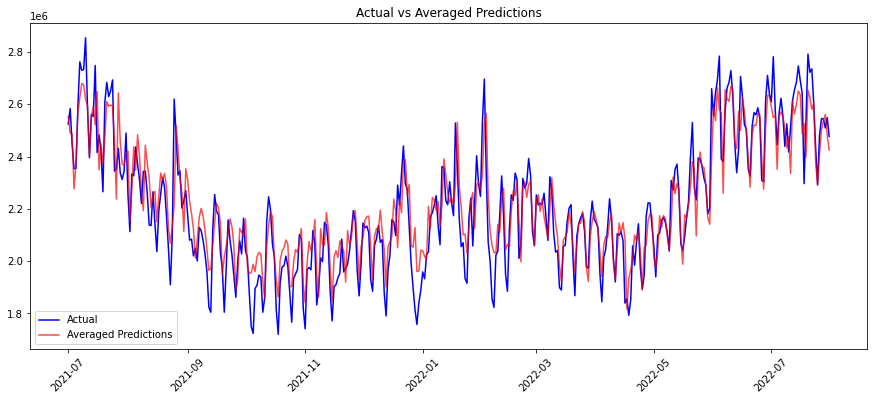

MAPE for Averaged Predictions: 3.68%


In [23]:
# Averaging Ensemble Predictions
avg_predictions = np.mean(np.array(all_predictions), axis=0)
avg_predictions_original = scaler.inverse_transform(np.concatenate((avg_predictions, testX[:,0,1:]), axis=1))[:,0]

# Inverse transform for the actual values
testY_original = scaler.inverse_transform(np.concatenate((testY.reshape(-1,1), testX[:,0,1:]), axis=1))[:,0]

# Plot Actual vs Averaged Predictions with Dates
plt.figure(figsize=(15,6))
plt.plot(test_dates, testY_original, label='Actual', color='blue')
plt.plot(test_dates, avg_predictions_original, label='Averaged Predictions', color='red', alpha=0.7)
plt.title('Actual vs Averaged Predictions')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Define MAPE function

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate MAPE

mape = mean_absolute_percentage_error(testY_original, avg_predictions_original)
print(f"MAPE for Averaged Predictions: {mape:.2f}%")

In [24]:
# Create a DataFrame with 'date', 'actual', and 'average predicted' fields
output_df = pd.DataFrame({
    'date': test_dates,
    'actual': testY_original,
    'average_predicted': avg_predictions_original
})

# Export the DataFrame to Excel
output_df.to_excel('predictions_output_nosolar.xlsx', index=False)